In [1]:
import os
import importlib

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from customer_segmentation.utils import functions
importlib.reload(functions)

# Set pandas to display all columns
pd.set_option("display.max_columns", None)

In [2]:
# import data
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, os.path.pardir, "data")
file_name = "cohort_data.csv"
file_path = os.path.join(data_dir, file_name)

cohort = pd.read_csv(file_path)

**convert data & seperate binary and numeric values**

In [9]:
cohort["user_id"] = cohort["user_id"].astype(str)
# get binary and numeric values
binary_cols = functions.get_binary_columns(cohort)
numeric_cols = (
    cohort.select_dtypes(include=[np.number]).columns.drop(binary_cols).to_list()
)

In [35]:
# scaling metrics

scaler = RobustScaler()
cohort_scaled = cohort[numeric_cols].copy()
cohort_scaled[numeric_cols] = scaler.fit_transform(cohort[numeric_cols])

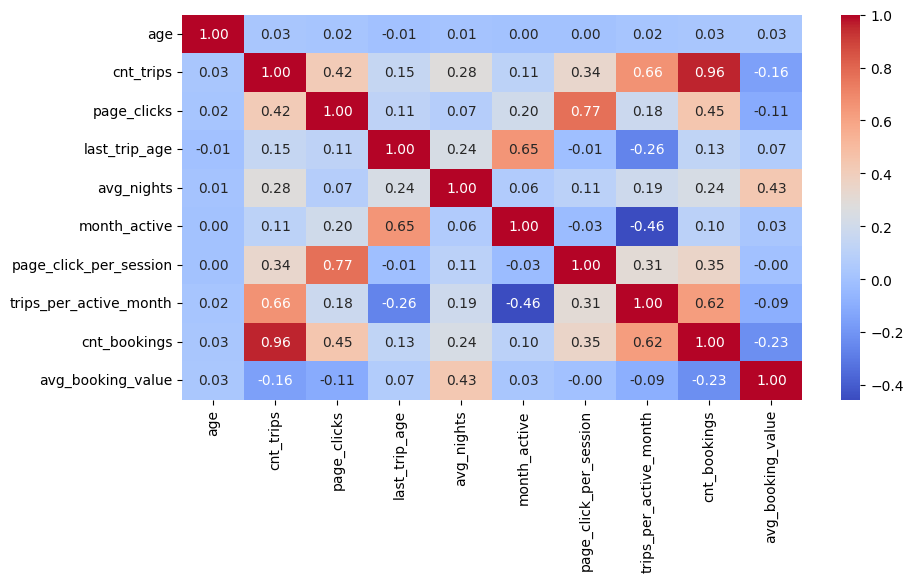

In [36]:
plt.figure(figsize=(10, 5))
sns.heatmap(cohort_scaled[numeric_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

In [37]:
# remove correlated & redundan features
cohort_scaled = cohort_scaled.drop(columns=["cnt_trips", "page_clicks"])

In [38]:
# add all features for clustering
cohort_binary = cohort[binary_cols]
cohort_binary.head()

,is_female,is_married,has_children,has_cancelled,is_flight_discount,is_hotel_discount,has_booked_flight,has_booked_hotel,has_baggage
0,1,0,0,0,1,1,1,1,1
1,0,0,1,0,1,1,0,1,0
2,0,1,0,0,1,0,1,1,1
3,0,0,0,0,1,1,0,0,0
4,0,0,0,0,0,1,1,1,1


In [39]:
cohort_scaled.head()

,age,last_trip_age,avg_nights,month_active,page_click_per_session,trips_per_active_month,cnt_bookings,avg_booking_value
0,-0.571429,1.025478,0.333333,1.088235,0.479592,-0.158841,0.666667,0.374019
1,-0.809524,1.585987,0.833333,1.813725,-0.816327,-0.558816,-0.333333,0.994158
2,0.380952,-0.165605,0.166667,0.598039,0.836735,0.796168,2.000000,0.135677
3,-0.857143,-0.547771,-0.500000,0.196078,0.387755,-0.818182,-0.666667,NaN
4,-0.238095,-0.261146,0.000000,0.558824,0.236735,0.003736,0.333333,-0.241511


In [40]:
# concat both data frames
cohort_cleaned = pd.concat([cohort_scaled, cohort_binary], axis=1)

cohort_cleaned = cohort_cleaned.fillna(0)
cohort_cleaned.head()

,age,last_trip_age,avg_nights,month_active,page_click_per_session,trips_per_active_month,cnt_bookings,avg_booking_value,is_female,is_married,has_children,has_cancelled,is_flight_discount,is_hotel_discount,has_booked_flight,has_booked_hotel,has_baggage
0,-0.571429,1.025478,0.333333,1.088235,0.479592,-0.158841,0.666667,0.374019,1,0,0,0,1,1,1,1,1
1,-0.809524,1.585987,0.833333,1.813725,-0.816327,-0.558816,-0.333333,0.994158,0,0,1,0,1,1,0,1,0
2,0.380952,-0.165605,0.166667,0.598039,0.836735,0.796168,2.000000,0.135677,0,1,0,0,1,0,1,1,1
3,-0.857143,-0.547771,-0.500000,0.196078,0.387755,-0.818182,-0.666667,0.000000,0,0,0,0,1,1,0,0,0
4,-0.238095,-0.261146,0.000000,0.558824,0.236735,0.003736,0.333333,-0.241511,0,0,0,0,0,1,1,1,1


In [ ]:
# only fit transform train data and transform test data (no fitting)

X_train, X_test, _, _ = train_test_split(
    cohort_scaled[:1], cohort_scaled[1:], test_size=0.4
)

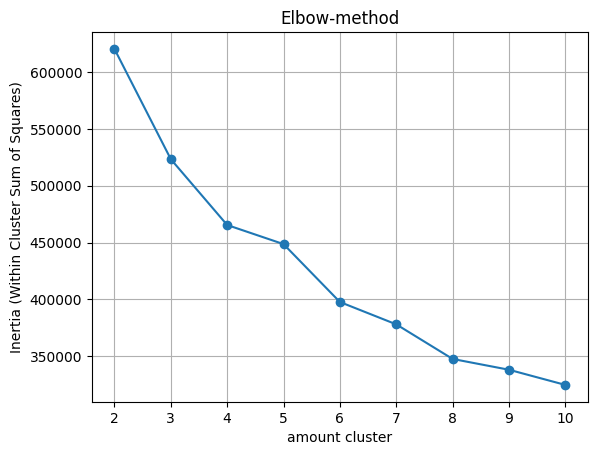

In [41]:
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(cohort_cleaned)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, "o-")
plt.xlabel("amount cluster")
plt.ylabel("Inertia (Within Cluster Sum of Squares)")
plt.title("Elbow-method")
plt.grid(True)
plt.show()

In [42]:
kmeans = KMeans(n_clusters=6, random_state=42, n_init="auto")
clusters = kmeans.fit_predict(cohort_cleaned)

# Cluster zu DataFrame hinzufügen
cohort["cluster"] = clusters

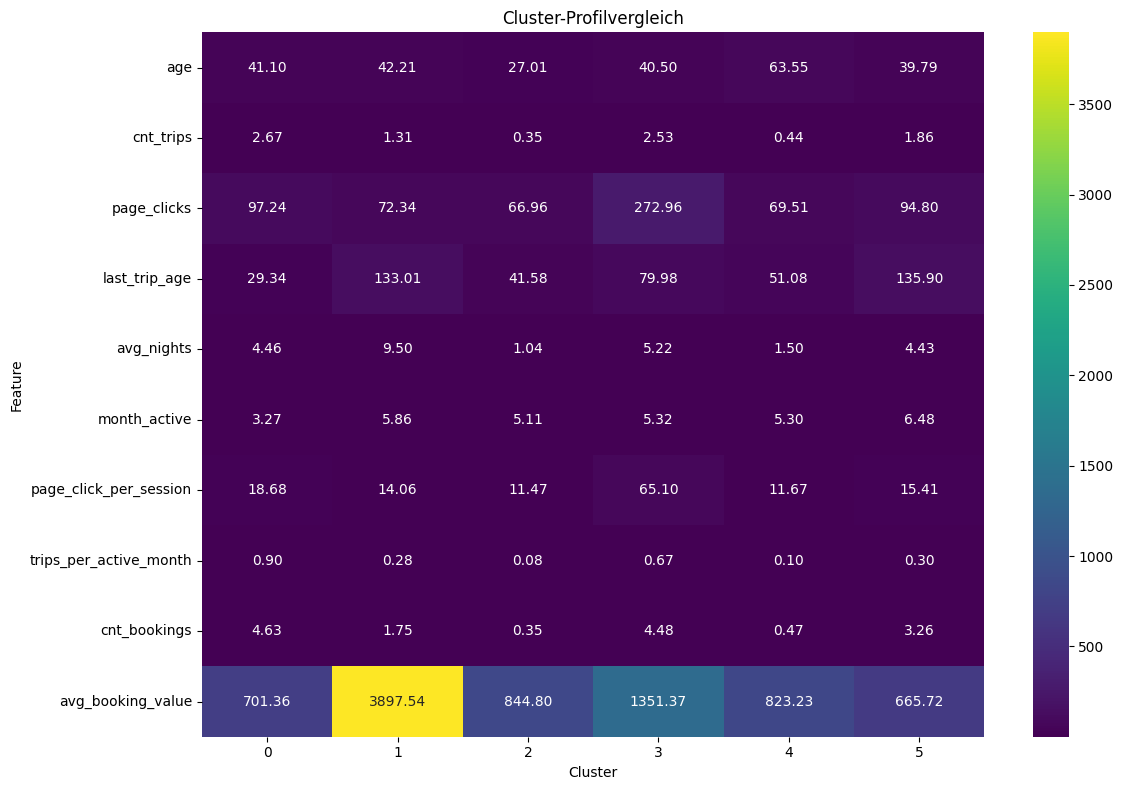

In [43]:
# Durchschnittswerte je Cluster
cluster_profiles = cohort.groupby("cluster")[numeric_cols].mean()

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_profiles.T, cmap="viridis", annot=True, fmt=".2f")
plt.title("Cluster-Profilvergleich")
plt.ylabel("Feature")
plt.xlabel("Cluster")
plt.tight_layout()
plt.show()